In [130]:
import pywt
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [ ]:
x = np.array([1,1])
y = np.arr

In [131]:
class dwt:
    def __init__(self, filter_size, h = None, g = None):
        if h is None:
            self.h = np.random.normal(1,2,filter_size)
        else:
            self.h = h
        
        if g is None:
            self.g = np.random.normal(1,2,filter_size)
        else:
            self.g = g
        
    def compute(self, input_):
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.dwt(input_, wavelet=my_wavelet)
    
    def inverse(self):
        return idwt(self)
    
    def update_weigths(self, hg, gg, lr = 0.001):
        self.h = self.h - lr*hg
        self.g = self.g - lr*gg

In [132]:
class idwt:
    def __init__(self, dwt):
        self.h = dwt.h
        self.g = dwt.g
    
    def compute(self, input_):
        ca,cd = input_
        filter_bank = [self.h, self.g, np.flip(self.h), np.flip(self.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return pywt.idwt(ca,cd, wavelet=my_wavelet)

In [133]:
def loss_function(h, g, x, x_, W):
    l1 = 0.5
    l2 = 0.5
    s1 = mean_squared_error(x, x_)
    s2 = np.sum(np.abs(W))
    s3 = lhg(h,g)
    return s1 + l1*s2 + l1*s3
    
def lhg(h, g):
    s1 = (np.sum(h**2) - 1)**2
    s2 = (np.sum(h) - math.sqrt(2))**2
    s3 = np.sum(g)**2
    return s1 + s2 + s3

In [134]:
def compute_gradient_h(h, g, x, loss_function, diff = 0.001):
    length = len(h)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        h_plus = h + mask
        h_minus = h - mask
        
        dwtp = dwt(1, h_plus, g)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h_minus, g)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h_plus, g, x, x_p, Wp)
        lossm = loss_function(h_minus, g, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient_g(h, g, x, loss_function, diff = 0.001):
    length = len(g)
    gradient = np.zeros(length)
    mask = np.zeros(length)
    for i in range(length):
        mask[i] = diff
        g_plus = g + mask
        g_minus = g - mask
        
        dwtp = dwt(1, h, g_plus)
        idwtp = dwtp.inverse()
        
        dwtm = dwt(1, h, g_minus)
        idwtm = dwtm.inverse()
        
        Wp = dwtp.compute(x)
        x_p = idwtp.compute(Wp)
        
        Wm = dwtm.compute(x)
        x_m = idwtm.compute(Wm)
        
        lossp = loss_function(h, g_plus, x, x_p, Wp)
        lossm = loss_function(h, g_minus, x, x_m, Wm)
        gradient[i] = (lossp - lossm)/diff
        
    return gradient

def compute_gradient(h, g, x, loss_function, diff = 0.001):
    hg = compute_gradient_h(h, g, x, loss_function, diff)
    gg = compute_gradient_g(h, g, x, loss_function, diff)
    return (hg, gg)
    
    
    

In [224]:
class Model:
    def __init__(self,filter_size = 2**5):
        self.my_dwt = dwt(filter_size)
        self.my_idwt = self.my_dwt.inverse()
        self.losses = []
        self.min_loss = math.inf
        
    def fit(self, x, epochs = 100, learning_rate = 0.001, verbose = True, good_error = None, diff = 0.000001):
        best_h = self.my_dwt.h
        best_g = self.my_idwt.g
        for i in range(epochs):
            W = self.my_dwt.compute(x)
            x_ = self.my_idwt.compute(W)
            loss = loss_function(self.my_dwt.h, self.my_dwt.g, x, x_, W)
            self.losses.append(loss)
            if loss < self.min_loss:
                self.min_loss = loss
                best_h = self.my_dwt.h
                best_g = self.my_dwt.g
            
            if verbose:
                print('Epochs #' + str(i+1) + ": " + str(loss) + " loss")
            
            if not good_error is None and loss <= good_error:
                return
            
            hg, gg = compute_gradient(self.my_dwt.h, self.my_dwt.g, x, loss_function, diff)
            self.my_dwt.update_weigths(hg, gg, learning_rate)
        
        self.my_dwt = dwt(1, best_h, best_g)
        self.my_idwt = self.my_dwt.inverse()
        print("Best Loss", self.min_loss)
    
    def predict(self, x):
        W = self.my_dwt.compute(x)
        return self.my_idwt.compute(W)
    
    def wavelet(self):
        filter_bank = [self.my_dwt.h, self.my_dwt.g, np.flip(self.my_dwt.h), np.flip(self.my_dwt.g)]
        my_wavelet = pywt.Wavelet(name="my_wavelet", filter_bank=filter_bank)
        return my_wavelet
    
    def dwt(self, x):
        ca, cd = self.my_dwt.compute(x)
        return np.concatenate([ca, cd])
    
        
            

## Testing

In [244]:
def generate_wave_coeff(length):
    result = []
    for _ in range(length*2):
        if np.random.random() < 0.9:
            result.append(0.0)
        else:
            result.append(np.random.uniform(-1,1))
    
    return (result[:length], result[length:])


def generate_signal(length, familie):    
    ca, cd = generate_wave_coeff(length)
    x = pywt.idwt(ca, cd, familie)
    return x


In [253]:
pywt.wavelist('sym')

['sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',
 'sym14',
 'sym15',
 'sym16',
 'sym17',
 'sym18',
 'sym19',
 'sym20']

In [254]:
x = generate_signal(32, 'sym2')

In [255]:
model = Model(4)

In [256]:
model.fit(x, epochs=500, learning_rate=0.001)

Epochs #1: 386.6400462371099 loss
Epochs #2: 197.44228664263932 loss
Epochs #3: 136.6144380715357 loss
Epochs #4: 106.52286382900414 loss
Epochs #5: 88.5029327965486 loss
Epochs #6: 76.42282017690053 loss
Epochs #7: 67.71301676581817 loss
Epochs #8: 61.100479842479125 loss
Epochs #9: 55.88413868139348 loss
Epochs #10: 51.64657220833866 loss
Epochs #11: 48.12378725233775 loss
Epochs #12: 45.14057514343567 loss
Epochs #13: 42.57596559313811 loss
Epochs #14: 40.34363391835123 loss
Epochs #15: 38.38022978889242 loss
Epochs #16: 36.6899434769077 loss
Epochs #17: 35.25747450641644 loss
Epochs #18: 33.96108670443204 loss
Epochs #19: 32.781624098328706 loss
Epochs #20: 31.703563887668864 loss
Epochs #21: 30.71417193735361 loss
Epochs #22: 29.802884874625533 loss
Epochs #23: 28.96085077013634 loss
Epochs #24: 28.18058277464975 loss
Epochs #25: 27.455694503884043 loss
Epochs #26: 26.780695457410545 loss
Epochs #27: 26.150831115590094 loss
Epochs #28: 25.561956695411563 loss
Epochs #29: 25.010436

Epochs #239: 7.868779624684442 loss
Epochs #240: 7.8438776721372685 loss
Epochs #241: 7.818864144334265 loss
Epochs #242: 7.794013300808054 loss
Epochs #243: 7.769323349215166 loss
Epochs #244: 7.744792530078236 loss
Epochs #245: 7.72041911561877 loss
Epochs #246: 7.696201408695323 loss
Epochs #247: 7.672194560206719 loss
Epochs #248: 7.648442845630126 loss
Epochs #249: 7.624655627959789 loss
Epochs #250: 7.6010188284953415 loss
Epochs #251: 7.577530835336686 loss
Epochs #252: 7.554190064351299 loss
Epochs #253: 7.5309949582815925 loss
Epochs #254: 7.507943985920864 loss
Epochs #255: 7.485035641330915 loss
Epochs #256: 7.462268443111323 loss
Epochs #257: 7.439640933650335 loss
Epochs #258: 7.417332081446165 loss
Epochs #259: 7.394974419200663 loss
Epochs #260: 7.372901426049924 loss
Epochs #261: 7.350827533779084 loss
Epochs #262: 7.328849929574288 loss
Epochs #263: 7.30700491186275 loss
Epochs #264: 7.285291122429234 loss
Epochs #265: 7.263707224505257 loss
Epochs #266: 7.242251902168

Epochs #481: 4.38684296031546 loss
Epochs #482: 4.378577859671074 loss
Epochs #483: 4.370343420728911 loss
Epochs #484: 4.362139529999258 loss
Epochs #485: 4.3539660749876115 loss
Epochs #486: 4.345822944191869 loss
Epochs #487: 4.337710027089876 loss
Epochs #488: 4.329627214121018 loss
Epochs #489: 4.321574396676985 loss
Epochs #490: 4.313551467094049 loss
Epochs #491: 4.307969328247965 loss
Epochs #492: 4.291099217781774 loss
Epochs #493: 4.274746007074716 loss
Epochs #494: 4.258890218523121 loss
Epochs #495: 4.243513135816741 loss
Epochs #496: 4.228861130295162 loss
Epochs #497: 4.226209947250129 loss
Epochs #498: 4.211729291607852 loss
Epochs #499: 4.197676634723928 loss
Epochs #500: 4.18403595704885 loss
Best Loss 4.18403595704885


reconstruction error: 0.10386358055959093


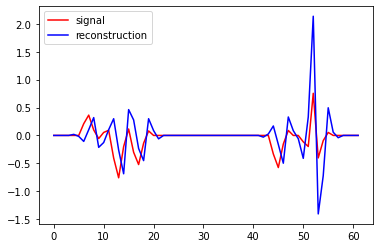

In [257]:
p = model.predict(x)
print("reconstruction error:", mean_squared_error(p,x))

plt.plot(np.arange(len(x)), x, c = 'r', label="signal")
plt.plot(np.arange(len(p)), p, c = 'b', label="reconstruction")
plt.legend()

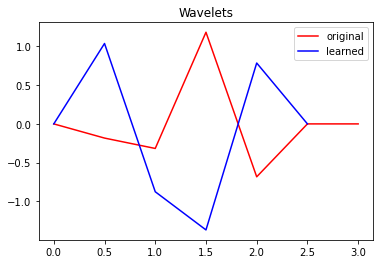

In [263]:
[phi_d,psi_d,phi_r,psi_r,al] = model.wavelet().wavefun(level=1)
[phi, psi, ao] = pywt.Wavelet('db2').wavefun(level=1)
lo = np.arange(len(ao))
plt.plot(ao, psi, c = 'r', label="original")
plt.plot(al,psi_d, c='b', label='learned')
plt.title("Wavelets")
plt.legend()

In [ ]:
pwy